Importing data and Libraries

In [ ]:
# Import the necessary libraries to implement it.
#!pip install tensorflow==1.14.0
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import ssl
import math
import matplotlib.pyplot as plt
import operator

from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score,accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D,BatchNormalization,GlobalMaxPooling1D,MaxPooling1D
from keras.regularizers import l2,l1
from keras.utils import to_categorical
from keras.optimizers import RMSprop, SGD, adam

# Import the Arrhythmia dataset from the library and replace missing values by '?'.
repo_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data"
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(repo_url, delimiter=',', header=None,)

# Make sure the data frame has 452 rows along with 280 columns.
df.shape

(452, 280)

Data Preprocessing

In [ ]:
# Split the frame as Data attribute and Class
df_data = df.iloc[:,:-1]
df_class = df.iloc[:,-1]

# Replace ? by NaN(Not A Number)
df_data = df_data.replace('?', np.NaN)

# Remove unwanted columns
# Deleting the attributes having more than 40% missing values.
thresh = len(df_data) * 0.4
df_data.dropna(thresh = thresh, axis = 1, inplace = True)

# Replace Missing values
# Imputing the remaining missing values with median of the values in the column
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='median')
imputer = imp_mean.fit(df_data)
df_imp = imputer.transform(df_data)
df_data = pd.DataFrame(df_imp)

# Attribute Scaling
# Normalize the values except for the class labels for each attribute using StandardScaler.
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(df_data.values)
df_data = pd.DataFrame(x_scaled, index = df_data.index)

print(df_data.shape)

(452, 278)


Split the data into train, test and validation.

---



---



In [ ]:
# Splitting into training and testing data

X_train, X_test, Y_train, Y_test = train_test_split(df_data, df_class, test_size=0.3, shuffle = True, stratify = df_class, random_state=43)

# Splitting into training and validation data
#X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, shuffle = True, stratify = Y_trainval, random_state=43)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(316, 278) (316,) (136, 278) (136,)


Determining the class weights for imbalanced dataset

In [ ]:
from sklearn.utils import class_weight
class_wt = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y_train),y=Y_train)
class_weights = dict(zip([1,2,3,4,5,6,7,8,9,10,14,15,16], class_wt),)
#class_weights[0] = 0
#class_weights[11] = 0
#class_weights[12] = 0
#class_weights[13] = 0
print(class_wt.sum())
print(class_weights)

print(np.bincount(Y_train))
print(np.bincount(Y_test))

66.48389473526794
{1: 0.14215024741340532, 2: 0.7841191066997518, 3: 2.2097902097902096, 4: 2.2097902097902096, 5: 2.700854700854701, 6: 1.4298642533936652, 7: 12.153846153846153, 8: 24.307692307692307, 9: 4.051282051282051, 10: 0.6945054945054945, 14: 8.102564102564102, 15: 6.076923076923077, 16: 1.6205128205128205}
[  0 171  31  11  11   9  17   2   1   6  35   0   0   0   3   4  15]
[ 0 74 13  4  4  4  8  1  1  3 15  0  0  0  1  1  7]


Random Forest Classifier

In [ ]:
# Implementation for Random forest
rfc = SelectFromModel(RandomForestClassifier(n_estimators = 20, random_state=0, n_jobs = -1))
rfc.fit(X_train, Y_train)

rfc_comp = X_train.columns[(rfc.get_support())]
print("Components from Feature Selection using Random Forest Classifier - ",len(rfc_comp))

# Transform the model to contain only the new data.
X_train_rfc= rfc.transform(X_train)
X_test_rfc = rfc.transform(X_test)
# Confirm that the transformed model has reduced components only
print(len(X_train_rfc[0]), len(X_test_rfc[0]))

Components from Feature Selection using Random Forest Classifier -  99
99 99


PCA

Components from Feature selection using PCA (Having Eigen values >=1) - 88

Feature Selection using PCA complete for the train data.




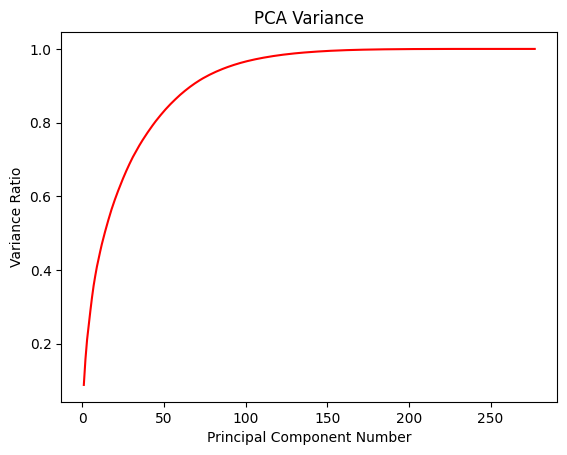

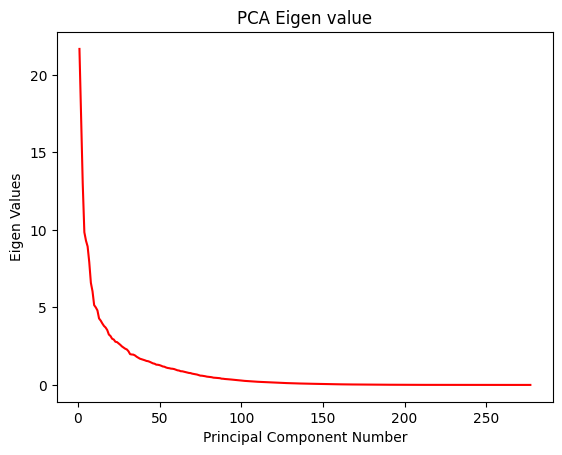

In [ ]:
# Implementation of PCA
pca_dict = {}
eigen_dict = {}
for n_comp in df_data.columns:
  pca = PCA(n_components=n_comp)
  temp_train_pca = pca.fit_transform(X_train)
  temp_test_pca = pca.transform(X_test)
  eigen_values = pca.explained_variance_[:n_comp]

  if n_comp > 0:
    #print (n_comp,pca.explained_variance_ratio_.sum(),eigen_values)[-1])
    pca_dict[n_comp] = pca.explained_variance_ratio_.sum()
    eigen_dict[n_comp] = eigen_values[-1]

f = plt.figure(1)
f.patch.set_facecolor('white')
plt.title('PCA Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Ratio')
plt.plot(list(pca_dict.keys()),list(pca_dict.values()),'r')
f.show()

g = plt.figure(2)
g.patch.set_facecolor('white')
plt.title('PCA Eigen value')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigen Values')
plt.plot(list(eigen_dict.keys()),list(eigen_dict.values()),'r')
g.show()

# Selecting components with Eigen value greater than 1 from the list
#pca_comp_eigen = max([key for key,val in eigen_dict.items() if val >= 1])
pca_comp_eigen = max([key for key,val in pca_dict.items() if val < 0.95])

print('Components from Feature selection using PCA (Having Eigen values >=1) - ' + str(pca_comp_eigen) + '\n')

# Performing PCA for the train data with the fixed components
pca = PCA(n_components=pca_comp_eigen)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('Feature Selection using PCA complete for the train data.\n\n')

SVM using PCA

SVM Accuracies - PCA: 
Linear kernal has maximum accuracy - 0.73529 for critical factor 0.01

Radial Basis Function Kernel SVM accuracy - 0.66176 for critical factor 100

Polynomial Kernel SVM has maximum accuracy - 0.68382 for critical factor 1000

Sigmoid Kernel SVM has maximum accuracy - 0.69853 for critical factor 1




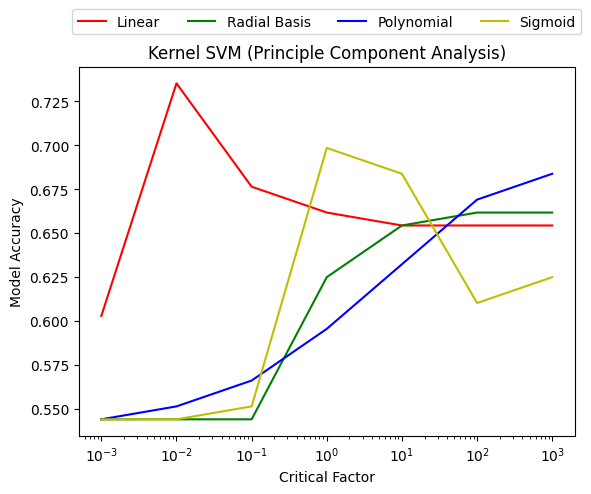

In [ ]:
# Hyperaeter tuning on regularization parameter and kernal for SVM
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernals = ['linear','rbf','poly','sigmoid']

pca_accuracy = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
#pca_f1_score = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}

for kernal in kernals:
  for cval in c_list:

    clf = SVC(max_iter=100000, kernel=kernal, C=cval)

    clf.fit(X_train_pca, Y_train)
    pca_accuracy[kernal].append(clf.score(X_test_pca, Y_test))
    yPred = clf.predict(X_test_pca)
    #pca_f1_score[kernal].append(f1_score(Y_test, yPred, average='weighted'))

    del clf
    del yPred

print('SVM Accuracies - PCA: ')
print('Linear kernal has maximum accuracy - '+ str(round(max(pca_accuracy['linear']),5)) + ' for critical factor ' + str(c_list[pca_accuracy['linear'].index(max(pca_accuracy['linear']))]) )
print('\nRadial Basis Function Kernel SVM accuracy - '+ str(round(max(pca_accuracy['rbf']),5)) + ' for critical factor ' + str(c_list[pca_accuracy['rbf'].index(max(pca_accuracy['rbf']))]) )
print('\nPolynomial Kernel SVM has maximum accuracy - ' + str(round(max(pca_accuracy['poly']),5)) + ' for critical factor ' + str(c_list[pca_accuracy['poly'].index(max(pca_accuracy['poly']))]))
print('\nSigmoid Kernel SVM has maximum accuracy - ' + str(round(max(pca_accuracy['sigmoid']),5)) + ' for critical factor ' + str(c_list[pca_accuracy['sigmoid'].index(max(pca_accuracy['sigmoid']))]) +'\n\n')

# Plot the Accuracy with C values
fig = plt.figure(1)
fig.patch.set_facecolor('white')
plt.xscale('log')
plt.title('Kernel SVM (Principle Component Analysis)')
plt.xlabel('Critical Factor')
plt.ylabel('Model Accuracy')
plt.plot(c_list, pca_accuracy['linear'], 'r', label = 'Linear')
plt.plot(c_list, pca_accuracy['rbf'], 'g', label = 'Radial Basis')
plt.plot(c_list, pca_accuracy['poly'], 'b', label = 'Polynomial')
plt.plot(c_list, pca_accuracy['sigmoid'], 'y', label = 'Sigmoid')
plt.legend(bbox_to_anchor = (0., 1.02, 1., .202), loc = 10, ncol=4, borderaxespad = 0)
fig.show()



SVM implementation using Random Forest Classifier

SVM Accuracies - Random Forest Classifier: 
Linear kernal has maximum accuracy - 0.73529 for critical factor 0.1

Radial Basis Function Kernel SVM accuracy - 0.71324 for critical factor 10

Polynomial Kernel SVM has maximum accuracy - 0.67647 for critical factor 10

Sigmoid Kernel SVM has maximum accuracy - 0.69853 for critical factor 1




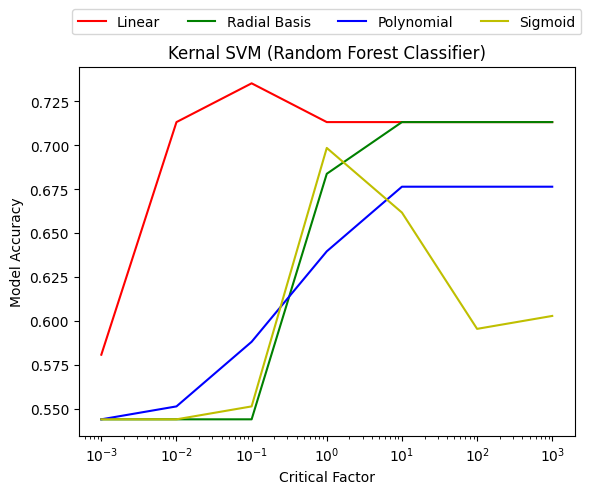

In [ ]:
# Hyperaeter tuning on regularization parameter and kernal for SVM
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernals = ['linear','rbf','poly','sigmoid']

rfc_accuracy = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
#rfc_f1_score = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}

for kernal in kernals:
  for cval in c_list:

    clf = SVC(max_iter=100000, kernel=kernal, C=cval)

    clf.fit(X_train_rfc, Y_train)
    rfc_accuracy[kernal].append(clf.score(X_test_rfc, Y_test))
    yPred = clf.predict(X_test_rfc)
    #pca_f1_score[kernal].append(f1_score(Y_test, yPred, average='weighted'))

    del clf
    del yPred

print('SVM Accuracies - Random Forest Classifier: ')
print('Linear kernal has maximum accuracy - '+ str(round(max(rfc_accuracy['linear']),5)) + ' for critical factor ' + str(c_list[rfc_accuracy['linear'].index(max(rfc_accuracy['linear']))]) )
print('\nRadial Basis Function Kernel SVM accuracy - '+ str(round(max(rfc_accuracy['rbf']),5)) + ' for critical factor ' + str(c_list[rfc_accuracy['rbf'].index(max(rfc_accuracy['rbf']))]) )
print('\nPolynomial Kernel SVM has maximum accuracy - ' + str(round(max(rfc_accuracy['poly']),5)) + ' for critical factor ' + str(c_list[rfc_accuracy['poly'].index(max(rfc_accuracy['poly']))]))
print('\nSigmoid Kernel SVM has maximum accuracy - ' + str(round(max(rfc_accuracy['sigmoid']),5)) + ' for critical factor ' + str(c_list[rfc_accuracy['sigmoid'].index(max(rfc_accuracy['sigmoid']))]) +'\n\n')

# Plot the Accuracy with C values
fig = plt.figure(1)
fig.patch.set_facecolor('white')
plt.xscale('log')
plt.title('Kernal SVM (Random Forest Classifier)')
plt.xlabel('Critical Factor')
plt.ylabel('Model Accuracy')
plt.plot(c_list, rfc_accuracy['linear'], 'r', label = 'Linear')
plt.plot(c_list, rfc_accuracy['rbf'], 'g', label = 'Radial Basis')
plt.plot(c_list, rfc_accuracy['poly'], 'b', label = 'Polynomial')
plt.plot(c_list, rfc_accuracy['sigmoid'], 'y', label = 'Sigmoid')
plt.legend(bbox_to_anchor = (0., 1.02, 1., .202), loc = 10, ncol=4, borderaxespad = 0)
fig.show()